In [1]:
import os
import sys
from time import sleep
import math
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)

import torch
from torchvision.transforms import v2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
# import seaborn_image as isns
import tqdm.notebook as tqdm
import gc

sys.path.append('../dataset_construction')
from pano_utils import *
from panoseti_file_interfaces import ObservingRunInterface

%load_ext autoreload


from cnn_model import *
from data_loaders import *
from training_utils import *
%autoreload 2

<Figure size 1500x1000 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset CloudDetectionInference
    Number of datapoints: 4679
    StandardTransform
Transform: Compose(
                 ToTensor()
                 ToDtype(scale=True)
           )


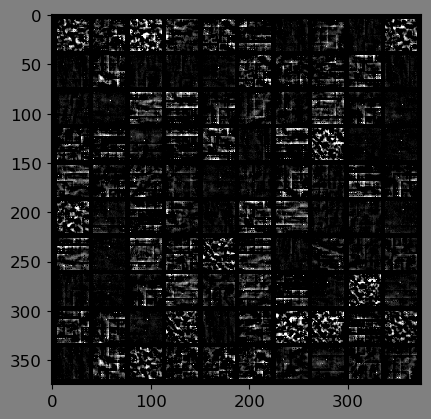

In [109]:
batch_size = 1024
batch_id = 10
img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-iifft'


transform = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float, scale=True)
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inference_data = CloudDetectionInference(
    batch_id = batch_id,
    transform = transform
)
inference_loader = torch.utils.data.DataLoader(
  dataset=inference_data,
  batch_size=batch_size
)
images = [inference_data[i][img_type]*10 for i in np.random.choice(len(inference_data), size=min(100, len(inference_data)), replace=False)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)))
print(inference_data)

# with open('../model_training/model_summary.txt', 'r') as f:
#     print(f.read())

In [118]:
model = CloudDetection()
# model.load_state_dict(torch.load('../model_training/best_cloud_detection_model_2-24-24.pth'))
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model_2-24-24_2.pth'))
device = get_device()
model.to(device);


predictions = np.array([], dtype=int)
with torch.no_grad():
    model.eval() # Put model in eval mode
    for img_data in tqdm.tqdm(inference_loader, unit="batch"):
        x = img_data[img_type]
        x = x.float().to(device)
        pred = model(x)
        # predictions = torch.cat((predictions, torch.argmax(pred, dim=1)))
        predictions = np.concatenate((predictions, torch.argmax(pred, dim=1).to('cpu').numpy()))
inference_data.inference_session.add_labels(predictions)
inference_data.inference_session.save_progress()
print(predictions)

  0%|          | 0/5 [00:00<?, ?batch/s]

[1 1 1 ... 1 1 1]


In [119]:
get_path = inference_data.inference_session.get_pano_feature_fpath
labeled = inference_data.inference_session.labeled_df

cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
clear = labeled[labeled['label'] == 'clear_night_sky']
print(f'ncloudy = {len(cloudy)}, nclear = {len(clear)}')

ncloudy = 3704, nclear = 975


In [132]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

plt.rcParams["figure.facecolor"] = 'grey'
plt.rcParams["font.size"] = 12
gc.collect()

cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
clear = labeled[labeled['label'] == 'clear_night_sky']

def make_img_grid(label, cols=8, rows_per_plot=6):
    """Grid of all classified images labeled as the given label"""
    with_label = labeled.loc[labeled['label'] == label]
    imgs = []

    for fuid in with_label['feature_uid']:
        data = np.load(get_path(fuid, img_type), allow_pickle=False)
        imgs.append(data)
    if len(imgs) == 0:
        print(f'No images labeled as "{label}"')
        return
    else:
        print(f'Images you classified as "{label}":')
    # Limit num rows in plot to ensure consistently-sized figures
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                feature_uid = with_label['feature_uid'].iloc[img_idx]
                ax.set_title(f'{23}{feature_uid[:6]}')  # Label each plot with first 6 chars of feature_uid
                ax.imshow(img, vmin=-150, vmax=150, cmap='icefire')
        plt.show()
        plt.close()

def plot_frame(label, step, i):
    if label == 'cloudy':
        with_label = cloudy
    elif label == 'clear':
        with_label = clear
    else:
        raise ValueError('label must be either "cloudy" or "clear"')
    fuid = with_label['feature_uid'].iloc[i - 1]
    data = np.load(get_path(fuid, img_type))    
    fig, axs = plt.subplots(1, 3, figsize=(11, 4.8), constrained_layout=True)
    fig.suptitle(f'[{label}] feature_uid: {fuid[:9]:>10}; ({(i-1)//step + 1} / {len(with_label) // step})')

    
    # FFT of original stacked original
    fft_idx = 0
    im_fft = axs[fft_idx].imshow(
        np.load(get_path(fuid, 'raw-fft')), vmin=4.5, vmax=10, cmap='icefire'
    )
    cbar_fft = fig.colorbar(im_fft, label='$\log|X[k, \ell]|$', fraction=0.046, location='bottom')
    axs[fft_idx].axis('off')
    axs[fft_idx].set_title('FFT of Original')

    
    # Original stacked pano image
    orig_idx = 2
    im_orig = axs[orig_idx].imshow(
        np.load(get_path(fuid, 'raw-original')), vmin=30, vmax=275, cmap='crest_r'
    )
    cbar_orig = fig.colorbar(im_orig, label='Counts', fraction=0.046, location='bottom')
    axs[orig_idx].axis('off')
    axs[orig_idx].set_title('Original')

    
    # -60 second time derivative
    deriv_idx = 1
    im_deriv = axs[deriv_idx].imshow(
        np.load(get_path(fuid, 'raw-derivative.-60')), vmin=-125, vmax=125, cmap='icefire'
    )
    cbar_deriv = fig.colorbar(im_deriv, label = r'$\Delta$ Counts', fraction=0.046, location='bottom')
    axs[deriv_idx].axis('off')
    axs[deriv_idx].set_title(f'$\Delta T = -60$s')
    plt.show()
    plt.close()



def do_movie(label, step, frame_time=0.01):
    try:
        # for i, fuid in enumerate(with_label['feature_uid'][::step]):
        if label == 'cloudy':
            with_label = cloudy
        elif label == 'clear':
            with_label = clear
        else:
            raise ValueError('label must be either "cloudy" or "clear"')
        for i in range(1, len(with_label) + 1, step):
            plot_frame(label, step, i)
            display.clear_output(wait=True)
            # plt.show()
            sleep(frame_time)
            # plt.close()
        print('Done')
    except KeyboardInterrupt:
        print('Exiting...')
        return
    finally:
        plt.close()
        gc.collect()


def browse_labels(continuous_update):
    try:
        initial_label = 'cloudy'
        initial_df = cloudy
        options = ['cloudy', 'clear']
        if len(cloudy) == 0 and len(clear) == 0:
            raise ValueError('No images!')
        elif len(cloudy) == 0:
            initial_label = 'clear'
            initial_df = clear
            options.remove('cloudy')
        i_widget = widgets.IntSlider(
            min=1, max=len(initial_df), step=1, value=1, 
            continuous_update=continuous_update, layout=Layout(width='85%', justify_content='center'),
            auto_advance=True
        )
        label_widget = widgets.Dropdown(
            options=options, value = initial_label, layout=Layout(width='50%', justify_content='center')
        )

        def update_i_widget(*args):
            if label_widget.value == 'cloudy':
                i_widget.max = len(cloudy)
                i_widget.value = min(i_widget.value, len(cloudy))
            elif label_widget.value == 'clear':
                i_widget.max = len(clear)
                i_widget.value = min(i_widget.value, len(clear))
                
        label_widget.observe(update_i_widget, 'value')
        interact(
            plot_frame,
            label = label_widget,
            step = fixed(1),
            i = i_widget
        )
    except KeyboardInterrupt:
        print('Exiting...')
        return
    finally:
        plt.close()
        gc.collect()
        

In [137]:
browse_labels(continuous_update=True)

interactive(children=(Dropdown(description='label', layout=Layout(justify_content='center', width='50%'), opti…

In [139]:
# View all cloudy images
# label can be set to either 'cloudy' or 'clear'
do_movie(label = 'clear', step=15)

Done


In [ ]:
make_img_grid('clear_night_sky')
make_img_grid('not_clear_cloudy')